# Getting started

Below example codes illustrate how to use different modules in [Pantea](https://pantea.readthedocs.io/).

## Initialization

In [1]:
# !gpustat

In [1]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"  # disable GPU

## Imports

In [2]:
import pantea
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

In [3]:
# from pantea.logger import set_logging_level
# import logging
# set_logging_level(logging.INFO)

## Dataset

### RuNNer
Read dataset in [RuNNer](https://www.uni-goettingen.de/de/560580.html) format.

In [8]:
from pantea.datasets import Dataset

base_dir = Path('.')
structures = Dataset.from_runner(base_dir / "input.data", persist=False)
print("Total number of structures:", len(structures))
# structures.preload()
structures

Total number of structures: 20


Dataset(datasource=RunnerDataSource(filename='input.data', dtype=float64), persist=False)

### Data loader

In [9]:
# from torch.utils.data import DataLoader

#### Split train and validation structures

In [10]:
# import torch
# validation_split = 0.032
# nsamples = len(structures)
# split = int(np.floor(validation_split * nsamples))
# train_structures, valid_structures = torch.utils.data.random_split(structures, lengths=[nsamples-split, split])
# structures = valid_structures

## Structure

In [13]:
s = structures[0]
s

Structure(natoms=12, elements=('H', 'O'), dtype=float64)

In [14]:
from ase.visualize import view
atoms = s.to_ase()
# view(atoms, viewer='ngl') # ase, ngl

In [15]:
from ase.io.vasp import write_vasp
write_vasp('POSCAR', atoms)

### Compare between structures

In [16]:
from pantea.utils.compare import compare
compare(structures[0], structures[1])

Comparing two structures, error metrics: RMSEpa


{'force_RMSEpa': Array(0.85609414, dtype=float64),
 'energy_RMSEpa': Array(0.01299882, dtype=float64)}

### Calculate distance between atoms

In [17]:
from pantea.atoms import calculate_distances
dis = calculate_distances(s, atom_indices=0)
dis[0, :5]

Array([0.        , 2.24720275, 3.85385356, 4.84207409, 7.55265933],      dtype=float64)

In [18]:
# sns.displot(dis.flatten(), bins=20)
# plt.axvline(dis.mean(), color='r');

### Find neighboring atom

In [19]:
from pantea.atoms import Neighbor

neighbor = Neighbor.from_structure(s, r_cutoff=10.0)
print(neighbor)
print("Number of neighbors for atom index 0:", jnp.sum(neighbor.masks[0]))

Neighbor(r_cutoff=10.0)
Number of neighbors for atom index 0: 11


### Per-atom energy offset

In [20]:
# structure = structures[0]
# atom_energy = {'O': 2.4, 'H': 1.2}

# structure.add_energy_offset(atom_energy)
# structure.total_energy

## Descriptor

Atomic environment descriptor.

In [21]:
from pantea.descriptors import ACSF
from pantea.descriptors.acsf import G2, G3, G9, CutoffFunction

In [22]:
acsf = ACSF('O')

cfn = CutoffFunction.from_cutoff_type(12.0, cutoff_type="tanhu")
g2_1 = G2(cfn, 0.0, 0.001)
g2_2 = G2(cfn, 0.0, 0.01)
g3_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)
g9_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)

acsf.add(g2_1, 'H')
acsf.add(g2_2, 'H')
acsf.add(g3_1, 'H', 'H')
acsf.add(g3_1, 'H', 'O')
acsf.add(g9_1, 'H', 'O')
acsf

ACSF(central_element='O', symmetry_functions=5)

### Computing descriptor values

In [23]:
val = acsf(s)
val[1, :]

Array([1.08272759e+00, 9.35614402e-01, 2.52484053e-04, 7.64628911e-06,
       7.64628911e-06], dtype=float64)

In [24]:
# sns.displot(val[:, 0], bins=20);

### Gradient

In [25]:
acsf.grad(structures[0], atom_index=2)

Array([[ 1.79978042e-02,  5.45284166e-02,  2.27747548e-02],
       [ 2.44782245e-02,  5.73790821e-02,  2.26291032e-02],
       [-4.11964454e-09,  4.37485864e-08,  2.58386814e-08],
       [-4.53174665e-06,  4.41009856e-04,  6.82317265e-05],
       [-4.53174665e-06,  4.41009856e-04,  6.82317265e-05]],      dtype=float64)

## Scaler

Descriptor scaler.

In [26]:
from pantea.descriptors import DescriptorScaler

### Fitting scaling parameters

In [27]:
scaler = DescriptorScaler(scale_type='scale_center')
# acsf = nnp.descriptor["H"]

for structure in tqdm(structures):
    x = acsf(structure)
    scaler.fit(x)

scaler

100%|██████████| 20/20 [00:00<00:00, 46.57it/s]


DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0)

In [28]:
scaled_x = []
for structure in tqdm(structures):
    x = acsf(structure)
    scaled_x.append(scaler(x))

scaled_x = jnp.concatenate(scaled_x, axis=0)
scaled_x.shape

100%|██████████| 20/20 [00:00<00:00, 87.49it/s]


(80, 5)

In [29]:
# sx = scaled_x[:, 5]
# sns.displot(sx, bins=30)
# plt.axvline(sx.mean(), color='r', lw=3);
# plt.axvline(0, color='k');

## Model

In [30]:
from pantea.models import NeuralNetworkModel
from pantea.models.nn import UniformInitializer
from flax import linen as nn

In [31]:
model = NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')))
model

NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')), param_dtype=float64)

In [35]:
rng = jax.random.PRNGKey(2022)                       # PRNG Key
x = jnp.ones(shape=(8, acsf.num_symmetry_functions)) # Dummy Input
params = model.init(rng, x)                          # Initialize the parameters
jax.tree.map(lambda x: x.shape, params)              # Check the parameters

{'params': {'layers_0': {'bias': (8,), 'kernel': (5, 8)},
  'layers_2': {'bias': (8,), 'kernel': (8, 8)},
  'layers_4': {'bias': (1,), 'kernel': (8, 1)}}}

### Computing output energy

In [36]:
energies = model.apply(params, scaled_x[:, :])

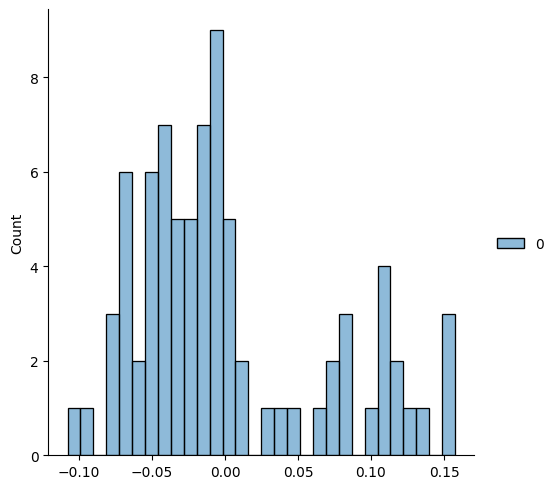

In [51]:
sns.displot(energies, bins=30);

## Atomic Potential

An atomic potential calculates the energy of a specific element in structures. It forms the basic building block of the final potential, which typically contains multiple elements. Atomic potential bundles up all the necessary components such as descriptors, scalers, and models in order to output the per-atomic energy.

In [40]:
from pantea.potentials import AtomicPotential

In [41]:
atomic_potential = AtomicPotential(
    descriptor=acsf,
    scaler=scaler,
    model=model,
)

atomic_potential

AtomicPotential(
  descriptor=ACSF(central_element='O', symmetry_functions=5),
  scaler=DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0),
  model=NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')), param_dtype=float64),
)

In [42]:
out =  atomic_potential.apply(params["params"], s)
out.shape

(4, 1)

In [43]:
energies = []
for structure in tqdm(structures):
    out = atomic_potential.apply(params['params'], structure)
    energies.append(out)

energies = jnp.concatenate(energies, axis=0)
energies.shape

100%|██████████| 20/20 [00:00<00:00, 62.15it/s]


(80, 1)

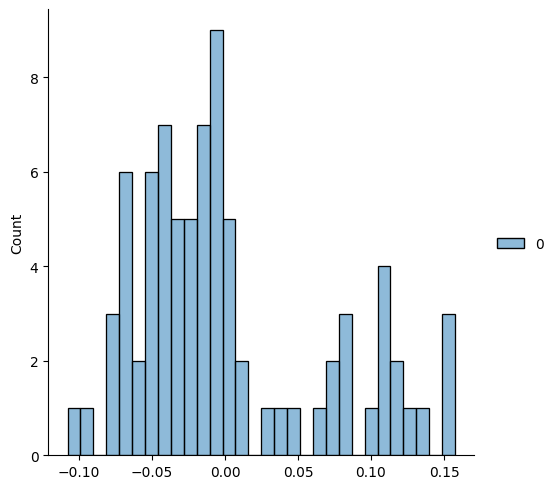

In [50]:
sns.displot(energies, bins=30);

Please note that the above graph is exactly the same graph as we obtained before by using the model.

## Neural Network Potential

An instance of neural network potential (NNP) including descirptor, scaler, and model for multiple elements can be initialzied directly from the input potential files. 

In [45]:
from pantea.datasets import Dataset
from pantea.potentials import NeuralNetworkPotential
from ase.visualize import view

### Read dataset

In [ ]:
base_dir = Path("GRN")

# Atomic data
structures = Dataset.from_runner(Path(base_dir, "input.data"))

# structures = [structures[i] for i in range(10)]
structure = structures[0]
structure
# view(structure.to_ase() * (3, 3, 2), viewer='ngl')

### Load potential parameters

In [48]:
# Potential
nnp = NeuralNetworkPotential.from_file(Path(base_dir, "input.nn"))

# nnp.save()
# nnp.load()

### Predictions

Warm-up period is bacause of the lazy class loading and just-in-time (JIT) compilation.

In [ ]:
total_energy = nnp(structure)
total_energy

In [ ]:
forces = nnp.compute_forces(structure)
forces[:5]